In [80]:
#!pip3 install imblearn

In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch as tc
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

import pandas as pd
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

In [82]:
train = pd.read_csv("/Users/nachikethinge/Documents/GitHub/Data-Mining-project/Data/Main_Data/fraudTrain.csv")
test = pd.read_csv("/Users/nachikethinge/Documents/Github/Data-Mining-project/Data/Main_Data/fraudTest.csv")

In [83]:
to_drop = ['first', 'last', 'street', 'city', 'street', 'job', 'trans_num', 'merchant']
train = train.drop(to_drop, axis = 1)
test = test.drop(to_drop, axis = 1)

In [84]:
#Create a new column DOB to calculate the age of the customer and convert trans_date_trans_time to datetime
train['dob'] = pd.to_datetime(train['dob'])
train['trans_date_trans_time'] = pd.to_datetime(train['trans_date_trans_time'])

test['dob'] = pd.to_datetime(test['dob'])
test['trans_date_trans_time'] = pd.to_datetime(test['trans_date_trans_time'])

#Calculate the age of the customer
train['age'] = 2023 - train['dob'].dt.year.astype(int)
test['age'] = 2023 - test['dob'].dt.year.astype(int)


In [85]:
train.head()

,Unnamed: 0,trans_date_trans_time,cc_num,category,amt,gender,state,zip,lat,long,city_pop,dob,unix_time,merch_lat,merch_long,is_fraud,age
0,0,2019-01-01 00:00:18,2703186189652095,misc_net,4.97,F,NC,28654,36.0788,-81.1781,3495,1988-03-09,1325376018,36.011293,-82.048315,0,35
1,1,2019-01-01 00:00:44,630423337322,grocery_pos,107.23,F,WA,99160,48.8878,-118.2105,149,1978-06-21,1325376044,49.159047,-118.186462,0,45
2,2,2019-01-01 00:00:51,38859492057661,entertainment,220.11,M,ID,83252,42.1808,-112.2620,4154,1962-01-19,1325376051,43.150704,-112.154481,0,61
3,3,2019-01-01 00:01:16,3534093764340240,gas_transport,45.00,M,MT,59632,46.2306,-112.1138,1939,1967-01-12,1325376076,47.034331,-112.561071,0,56
4,4,2019-01-01 00:03:06,375534208663984,misc_pos,41.96,M,VA,24433,38.4207,-79.4629,99,1986-03-28,1325376186,38.674999,-78.632459,0,37


In [86]:
train['trans_year'] = train['trans_date_trans_time'].dt.year.astype(int)
train['trans_month'] = train['trans_date_trans_time'].dt.month.astype(int)
train['trans_hour'] = train['trans_date_trans_time'].dt.hour.astype(int)

test['trans_year'] = test['trans_date_trans_time'].dt.year.astype(int)
test['trans_month'] = test['trans_date_trans_time'].dt.month.astype(int)
test['trans_hour'] = test['trans_date_trans_time'].dt.hour.astype(int)

In [87]:
#Drop trans_date_trans_time and dob
train = train.drop('trans_date_trans_time', axis = 1)
train = train.drop('dob', axis = 1)

test = test.drop('trans_date_trans_time', axis = 1)
test = test.drop('dob', axis = 1)

In [88]:
#Map Gender F to 0 and M to 1 in training and testing dataset
gender_map = {'F': 0, 'M': 1}
train['gender'] = train['gender'].map(gender_map)
test['gender'] = test['gender'].map(gender_map)

In [89]:
#Using LabelEcoder to encode the categorical variables for "Category" and "State"
le = LabelEncoder()
train['category'] = le.fit_transform(train['category'])
test['category'] = le.fit_transform(test['category'])

train['state'] = le.fit_transform(train['state'])
test['state'] = le.fit_transform(test['state'])

In [90]:
#Using OneHotEncoder to encode the categorical variables for "Category" and "State"
ohe = OneHotEncoder()
train_cat = ohe.fit_transform(train['category'].values.reshape(-1, 1)).toarray()
test_cat = ohe.fit_transform(test['category'].values.reshape(-1, 1)).toarray()

train_state = ohe.fit_transform(train['state'].values.reshape(-1, 1)).toarray()
test_state = ohe.fit_transform(test['state'].values.reshape(-1, 1)).toarray()

In [91]:
#Convert the encoded categorical variables to dataframe
train_cat = pd.DataFrame(train_cat, columns = ['cat_' + str(int(i)) for i in range(train_cat.shape[1])])
test_cat = pd.DataFrame(test_cat, columns = ['cat_' + str(int(i)) for i in range(test_cat.shape[1])])

train_state = pd.DataFrame(train_state, columns = ['state_' + str(int(i)) for i in range(train_state.shape[1])])
test_state = pd.DataFrame(test_state, columns = ['state_' + str(int(i)) for i in range(test_state.shape[1])])

In [92]:
#Drop the original categorical variables
train = train.drop(['category', 'state'], axis = 1)
test = test.drop(['category', 'state'], axis = 1)

#Concatenate the encoded categorical variables to the original dataset
train = pd.concat([train, train_cat, train_state], axis = 1)
test = pd.concat([test, test_cat, test_state], axis = 1)

In [93]:
#Scale the numerical variables
numerical_features = ['amt', 'lat', 'long', 'city_pop', 'unix_time', 'merch_lat', 'merch_long']
scaler = StandardScaler()
train[numerical_features] = scaler.fit_transform(train[numerical_features])
test[numerical_features] = scaler.fit_transform(test[numerical_features])

In [94]:
#Drop the cc_num column
train = train.drop('cc_num', axis = 1)
test = test.drop('cc_num', axis = 1)

In [95]:
df = pd.concat([train, test], axis=0).sample(100000, random_state=1)
X = df.drop('is_fraud', axis=1)
y = df['is_fraud']

#drop state_50 
X = X.drop('state_50', axis = 1)




In [96]:
# Split the dataset into training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

# Apply SMOTE to balance the training dataset
smote = SMOTE(random_state=1)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Print the number of fraud and non-fraud cases in the balanced training dataset
fraud_count = sum(y_train_balanced == 1)
non_fraud_count = sum(y_train_balanced == 0)
print(f"Fraud in y_train_balanced: {fraud_count}")
print(f"Non-fraud in y_train_balanced: {non_fraud_count}")

# Print the number of fraud and non-fraud cases in the testing dataset
fraud_count = sum(y_test == 1)
non_fraud_count = sum(y_test == 0)
print(f"Fraud in y_test: {fraud_count}")
print(f"Non-fraud in y_test: {non_fraud_count}")

Fraud in y_train_balanced: 69637
Non-fraud in y_train_balanced: 69637
Fraud in y_test: 155
Non-fraud in y_test: 29845


In [97]:
X_test

,Unnamed: 0,amt,gender,zip,lat,long,city_pop,unix_time,merch_lat,merch_long,...,state_40,state_41,state_42,state_43,state_44,state_45,state_46,state_47,state_48,state_49
360076,360076,-0.394228,0,94015,-0.169219,-2.344029,0.063309,-0.729286,-0.201356,-2.334907,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
217645,217645,-0.000443,1,42634,-0.335498,0.420285,-0.288980,-1.111863,-0.233766,0.380830,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
893589,893589,0.124872,1,18246,0.476058,1.021263,-0.293690,0.557213,0.431260,1.045891,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
150051,150051,-0.016037,0,43330,0.448279,0.494709,-0.293772,-1.312225,0.374282,0.454749,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
366057,366057,-0.409534,0,61830,0.287266,0.111875,-0.292099,0.650213,0.198449,0.079776,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
747347,747347,0.944753,0,44233,0.532778,0.616396,-0.268842,0.296140,0.614577,0.623490,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
608689,608689,-0.175223,1,40077,-0.008968,0.346966,-0.292295,-0.117685,-0.171742,0.333106,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
54812,54812,-0.274652,1,97132,1.334227,-2.379678,-0.200514,-1.639037,1.220758,-2.365101,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
756530,756530,-0.379632,1,13752,0.719369,1.112243,-0.291574,0.318384,0.586443,1.129936,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [98]:
#Drop 'Unnamed:0' column from train and test
X_train_balanced = X_train_balanced.drop('Unnamed: 0', axis = 1)
X_test = X_test.drop('Unnamed: 0', axis = 1)

In [99]:
X_train_balanced.head()

,amt,gender,zip,lat,long,city_pop,unix_time,merch_lat,merch_long,age,...,state_40,state_41,state_42,state_43,state_44,state_45,state_46,state_47,state_48,state_49
0,2.182688,1,33809,-2.048286,0.602854,0.496221,0.866660,-2.178514,0.593080,74,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.768743,1,50421,0.851129,-0.246956,-0.283597,-1.359385,1.007113,-0.286466,59,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.407876,0,47451,0.069260,0.270135,-0.289603,1.020908,0.184032,0.333590,32,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.221943,0,17058,0.397509,0.932202,-0.287841,0.164528,0.212349,0.942366,69,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.420364,1,13811,0.727072,1.022150,-0.279744,0.036873,0.849615,0.981946,29,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [100]:
#Creat a class for the dataset
class CreditCardDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.len = len(X)
    
    def __getitem__(self, index):
        return self.X.iloc[index], self.y.iloc[index]
    
    def __len__(self):
        return self.len
    
train_dataset = CreditCardDataset(X_train_balanced, y_train_balanced)
test_dataset = CreditCardDataset(X_test, y_test)

In [101]:
def custom_collate(batch):
    X = tc.stack([tc.tensor(item[0].values.astype('float32')) for item in batch])
    y = tc.stack([tc.tensor(item[1].astype('float32')) for item in batch])
    return X, y

In [102]:
batch_size = 32
train_loader = DataLoader(dataset = train_dataset, batch_size = batch_size, shuffle = True, collate_fn = custom_collate)
test_loader = DataLoader(dataset = test_dataset, batch_size = batch_size, shuffle = True, collate_fn = custom_collate)

In [103]:
#Create a class for MLPBinaryClassifier using Neural Network
class MLPBinaryClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLPBinaryClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        out = self.sigmoid(out)
        return out

In [104]:
assert X_train_balanced.shape[1] == X_test.shape[1]

In [107]:
input_size = X_train_balanced.shape[1]
hidden_size = 100
output_size = 1

model = MLPBinaryClassifier(input_size, hidden_size, output_size)

#Define the loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

epochs = 5
loss_history = []

In [108]:
for epoch in range(epochs):
    for i, (X, y) in enumerate(train_loader):
        y = y.unsqueeze(1)
        y_pred = model(X)
        loss = criterion(y_pred, y)
        loss_history.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print("Epoch: {}/{}, Loss: {}".format(epoch+1, epochs, loss.item()))

Epoch: 0/5, Loss: 50.0
Epoch: 1/5, Loss: 60.0
Epoch: 2/5, Loss: 20.0
Epoch: 3/5, Loss: 70.0
Epoch: 4/5, Loss: 30.0


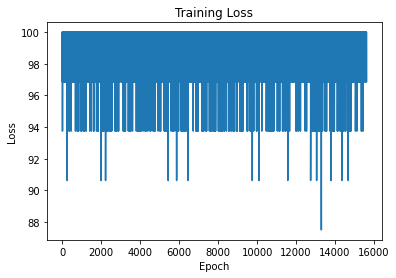

In [ ]:
import matplotlib.pyplot as plt

plt.plot(loss_history)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()


In [ ]:
model.eval()
y_pred = []
y_true = []

with tc.no_grad():
    for X_batch, y_batch in test_loader:
        y_pred_batch = model(X_batch)
        y_pred.extend(y_pred_batch.round().detach().numpy())
        y_true.extend(y_batch.detach().numpy())
        
accuracy = accuracy_score(y_true, y_pred)
print(f"The accuracy of the model is: {round(accuracy, 4) * 100}%")

The accuracy of the model is: 0.38999999999999996%


In [109]:
#Create a confusion matrix
cm = confusion_matrix(y_true, y_pred)
print(cm)



ValueError: Found input variables with inconsistent numbers of samples: [100000, 10]